# Evaluate classification thresholds

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
sns.set_theme()

In [4]:
directory = '../processed_data/classification_threshold_evaluation'

## Actual train and test labels

In [5]:
file = 'actual.csv'
path = os.path.join(directory, file)
actual = pd.read_csv(path)
actual

,system:index,crop,subset,.geo
0,00000000000000000008,0,train,"{""type"":""Point"",""coordinates"":[25.895515911718..."
1,00000000000000000013,0,train,"{""type"":""Point"",""coordinates"":[25.523341501393..."
2,00000000000000000097,0,train,"{""type"":""Point"",""coordinates"":[25.894789078246..."
3,000000000000000000ba,0,train,"{""type"":""Point"",""coordinates"":[25.644584459036..."
4,000000000000000000e2,0,train,"{""type"":""Point"",""coordinates"":[25.509411269702..."
...,...,...,...,...
979,00000000000000004d17,1,test,"{""type"":""Point"",""coordinates"":[26.032526250686..."
980,00000000000000004d84,1,test,"{""type"":""Point"",""coordinates"":[26.087382111846..."
981,00000000000000004d96,1,test,"{""type"":""Point"",""coordinates"":[26.244378141735..."
982,00000000000000004dc3,1,test,"{""type"":""Point"",""coordinates"":[26.151972190605..."


In [6]:
actual['lon'] = actual.apply(lambda x: eval(x['.geo'])['coordinates'][0], axis=1)
actual['lat'] = actual.apply(lambda x: eval(x['.geo'])['coordinates'][1], axis=1)
actual = actual.drop('.geo', axis=1)
actual

,system:index,crop,subset,lon,lat
0,00000000000000000008,0,train,25.895516,-16.804194
1,00000000000000000013,0,train,25.523342,-17.016228
2,00000000000000000097,0,train,25.894789,-16.837829
3,000000000000000000ba,0,train,25.644584,-17.004385
4,000000000000000000e2,0,train,25.509411,-16.876427
...,...,...,...,...,...
979,00000000000000004d17,1,test,26.032526,-16.713750
980,00000000000000004d84,1,test,26.087382,-16.838992
981,00000000000000004d96,1,test,26.244378,-16.785488
982,00000000000000004dc3,1,test,26.151972,-16.746925


In [7]:
actual['subset'].value_counts()

train    787
test     197
Name: subset, dtype: int64

## Random forest trained on KAZA Bengo Crop 2020 Random 20000 dataset

In [8]:
file = 'random_forest_class_probabilities.csv'
path = os.path.join(directory, file)
random_forest_predicted = pd.read_csv(path)
random_forest_predicted

,system:index,B2,B3,B4,B8,NDVI,classification,crop,.geo
0,00000000000000003e85_0,0.029833,0.044433,0.038533,0.220833,0.702531,0.042934,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,00000000000000003ec4_0,0.024733,0.036733,0.028600,0.190467,0.719469,0.033010,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,00000000000000003efd_0,0.036567,0.060000,0.056367,0.285367,0.670187,0.370398,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,00000000000000003f9c_0,0.050933,0.076900,0.081600,0.245567,0.502238,0.285553,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,00000000000000003fb4_0,0.048700,0.077867,0.078367,0.258100,0.534403,0.465381,0,"{""type"":""MultiPoint"",""coordinates"":[]}"
...,...,...,...,...,...,...,...,...,...
192,00000000000000004d17_0,0.064500,0.103400,0.127267,0.294800,0.399499,0.981217,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
193,00000000000000004d84_0,0.051617,0.082017,0.098200,0.256950,0.448474,0.745972,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
194,00000000000000004d96_0,0.096633,0.134600,0.166200,0.272800,0.245748,0.843436,1,"{""type"":""MultiPoint"",""coordinates"":[]}"
195,00000000000000004dc3_0,0.045750,0.074850,0.090317,0.255867,0.479534,0.774158,1,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [9]:
random_forest_predicted['system:index'] = random_forest_predicted['system:index'].apply(lambda x: x.split('_')[0])
random_forest_predicted = random_forest_predicted[['system:index', 'classification']]
random_forest_predicted = pd.merge(actual, random_forest_predicted, how='inner', on='system:index')
random_forest_predicted = random_forest_predicted.drop(['system:index', 'lon', 'lat'], axis=1)
random_forest_predicted = random_forest_predicted.rename(columns={'classification': 'crop_probability'})
random_forest_predicted

,crop,subset,crop_probability
0,0,test,0.042934
1,0,test,0.033010
2,0,test,0.370398
3,0,test,0.285553
4,0,test,0.465381
...,...,...,...
192,1,test,0.981217
193,1,test,0.745972
194,1,test,0.843436
195,1,test,0.774158


In [10]:
thresholds = np.arange(0.1,1.1,0.1)
actual_test_labels = list(random_forest_predicted['crop'])
accuracies_rf = []
for threshold in thresholds:
    predicted = [1 if i >= threshold else 0 for i in list(random_forest_predicted['crop_probability'])]
    accuracy = round(accuracy_score(actual_test_labels, predicted), 2)
    accuracies_rf.append(accuracy)    
    print(round(threshold, 1), accuracy)

0.1 0.68
0.2 0.77
0.3 0.8
0.4 0.83
0.5 0.85
0.6 0.84
0.7 0.81
0.8 0.76
0.9 0.69
1.0 0.47


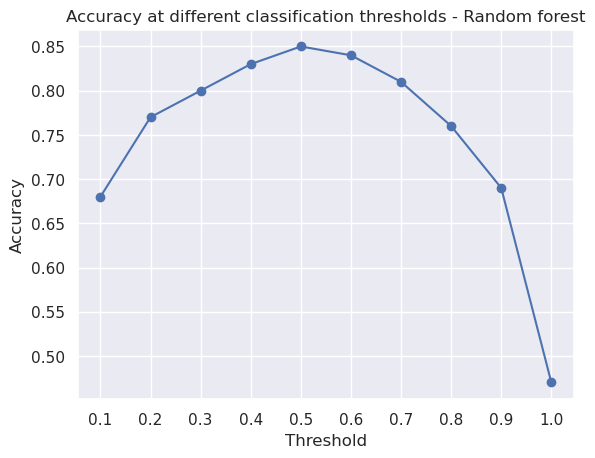

In [11]:
plt.plot(thresholds, accuracies_rf, marker='o')
plt.xticks(thresholds)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy at different classification thresholds - Random forest')
plt.show()

# OpenMapFlow trained on Geowiki Landcover 2017 and Togo Crop 2019

In [12]:
openmapflow_predicted = pd.DataFrame()
for threshold in thresholds:
    if threshold == 1.0:
        threshold = 1
    file = 'openmapflow_threshold_' + str(round(threshold, 2)).replace('.', '_') + '.csv'
    path = os.path.join(directory, file)
    openmapflow_predicted_ = pd.read_csv(path)
    openmapflow_predicted_['threshold'] = threshold
    openmapflow_predicted = pd.concat([openmapflow_predicted, openmapflow_predicted_], ignore_index=True)
openmapflow_predicted

,system:index,count,prediction,.geo,threshold
0,+10005+823,1,1,"{""geodesic"":false,""type"":""Point"",""coordinates""...",0.1
1,+1001+3264,1,1,"{""geodesic"":false,""type"":""Point"",""coordinates""...",0.1
2,+10029+1445,1,1,"{""geodesic"":false,""type"":""Point"",""coordinates""...",0.1
3,+10035+1178,1,1,"{""geodesic"":false,""type"":""Point"",""coordinates""...",0.1
4,+10036+1888,1,1,"{""geodesic"":false,""type"":""Point"",""coordinates""...",0.1
...,...,...,...,...,...
9835,+997+3173,1,0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1.0
9836,+9979+1567,1,0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1.0
9837,+9980+1112,1,0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1.0
9838,+9984+2244,1,0,"{""geodesic"":false,""type"":""Point"",""coordinates""...",1.0


In [13]:
openmapflow_predicted['lon'] = openmapflow_predicted.apply(lambda x: eval(x['.geo'].replace('false', '0'))['coordinates'][0], axis=1)
openmapflow_predicted['lat'] = openmapflow_predicted.apply(lambda x: eval(x['.geo'].replace('false', '0'))['coordinates'][1], axis=1)
openmapflow_predicted = openmapflow_predicted.drop(['system:index', 'count', '.geo'], axis=1)
openmapflow_predicted

,prediction,threshold,lon,lat
0,1,0.1,26.095745,-16.721914
1,1,0.1,25.286902,-16.941193
2,1,0.1,26.097901,-16.777790
3,1,0.1,26.098440,-16.753805
4,1,0.1,26.098529,-16.817585
...,...,...,...,...
9835,0,1.0,25.286542,-16.933019
9836,0,1.0,26.093409,-16.788749
9837,0,1.0,26.093499,-16.747876
9838,0,1.0,26.093858,-16.849565


In [14]:
openmapflow_predicted = gpd.GeoDataFrame(openmapflow_predicted, geometry=gpd.points_from_xy(openmapflow_predicted.lon, openmapflow_predicted.lat))
openmapflow_predicted

,prediction,threshold,lon,lat,geometry
0,1,0.1,26.095745,-16.721914,POINT (26.09574 -16.72191)
1,1,0.1,25.286902,-16.941193,POINT (25.28690 -16.94119)
2,1,0.1,26.097901,-16.777790,POINT (26.09790 -16.77779)
3,1,0.1,26.098440,-16.753805,POINT (26.09844 -16.75380)
4,1,0.1,26.098529,-16.817585,POINT (26.09853 -16.81759)
...,...,...,...,...,...
9835,0,1.0,25.286542,-16.933019,POINT (25.28654 -16.93302)
9836,0,1.0,26.093409,-16.788749,POINT (26.09341 -16.78875)
9837,0,1.0,26.093499,-16.747876,POINT (26.09350 -16.74788)
9838,0,1.0,26.093858,-16.849565,POINT (26.09386 -16.84957)


In [15]:
actual = gpd.GeoDataFrame(actual, geometry=gpd.points_from_xy(actual.lon, actual.lat))
actual

,system:index,crop,subset,lon,lat,geometry
0,00000000000000000008,0,train,25.895516,-16.804194,POINT (25.89552 -16.80419)
1,00000000000000000013,0,train,25.523342,-17.016228,POINT (25.52334 -17.01623)
2,00000000000000000097,0,train,25.894789,-16.837829,POINT (25.89479 -16.83783)
3,000000000000000000ba,0,train,25.644584,-17.004385,POINT (25.64458 -17.00439)
4,000000000000000000e2,0,train,25.509411,-16.876427,POINT (25.50941 -16.87643)
...,...,...,...,...,...,...
979,00000000000000004d17,1,test,26.032526,-16.713750,POINT (26.03253 -16.71375)
980,00000000000000004d84,1,test,26.087382,-16.838992,POINT (26.08738 -16.83899)
981,00000000000000004d96,1,test,26.244378,-16.785488,POINT (26.24438 -16.78549)
982,00000000000000004dc3,1,test,26.151972,-16.746925,POINT (26.15197 -16.74693)


In [16]:
openmapflow_predicted = gpd.sjoin_nearest(openmapflow_predicted, actual, how='inner')
openmapflow_predicted

,prediction,threshold,lon_left,lat_left,geometry,index_right,system:index,crop,subset,lon_right,lat_right
0,1,0.1,26.095745,-16.721914,POINT (26.09574 -16.72191),779,00000000000000002c72,1,train,26.095761,-16.721928
984,1,0.2,26.095745,-16.721914,POINT (26.09574 -16.72191),779,00000000000000002c72,1,train,26.095761,-16.721928
1968,1,0.3,26.095745,-16.721914,POINT (26.09574 -16.72191),779,00000000000000002c72,1,train,26.095761,-16.721928
2952,1,0.4,26.095745,-16.721914,POINT (26.09574 -16.72191),779,00000000000000002c72,1,train,26.095761,-16.721928
3936,0,0.5,26.095745,-16.721914,POINT (26.09574 -16.72191),779,00000000000000002c72,1,train,26.095761,-16.721928
...,...,...,...,...,...,...,...,...,...,...,...
5903,0,0.6,26.094577,-16.812195,POINT (26.09458 -16.81220),784,00000000000000002dc1,1,train,26.094619,-16.812233
6887,0,0.7,26.094577,-16.812195,POINT (26.09458 -16.81220),784,00000000000000002dc1,1,train,26.094619,-16.812233
7871,0,0.8,26.094577,-16.812195,POINT (26.09458 -16.81220),784,00000000000000002dc1,1,train,26.094619,-16.812233
8855,0,0.9,26.094577,-16.812195,POINT (26.09458 -16.81220),784,00000000000000002dc1,1,train,26.094619,-16.812233


In [17]:
openmapflow_predicted[openmapflow_predicted['threshold'] == 0.1]

,prediction,threshold,lon_left,lat_left,geometry,index_right,system:index,crop,subset,lon_right,lat_right
0,1,0.1,26.095745,-16.721914,POINT (26.09574 -16.72191),779,00000000000000002c72,1,train,26.095761,-16.721928
1,1,0.1,25.286902,-16.941193,POINT (25.28690 -16.94119),209,00000000000000002050,0,train,25.286858,-16.941186
2,1,0.1,26.097901,-16.777790,POINT (26.09790 -16.77779),824,00000000000000003392,1,train,26.097906,-16.777823
3,1,0.1,26.098440,-16.753805,POINT (26.09844 -16.75380),807,000000000000000031bd,1,train,26.098481,-16.753846
4,1,0.1,26.098529,-16.817585,POINT (26.09853 -16.81759),855,000000000000000038d6,1,train,26.098503,-16.817544
...,...,...,...,...,...,...,...,...,...,...,...
979,1,0.1,25.286542,-16.933019,POINT (25.28654 -16.93302),425,00000000000000004359,0,test,25.286577,-16.932981
980,1,0.1,26.093409,-16.788749,POINT (26.09341 -16.78875),534,0000000000000000039a,1,train,26.093429,-16.788747
981,1,0.1,26.093499,-16.747876,POINT (26.09350 -16.74788),897,000000000000000040fb,1,test,26.093460,-16.747844
982,1,0.1,26.093858,-16.849565,POINT (26.09386 -16.84957),693,00000000000000001eb5,1,train,26.093843,-16.849552


In [18]:
accuracies_omf = []
for threshold in thresholds:
    predicted = list(openmapflow_predicted[(openmapflow_predicted['subset'] == 'test') & (openmapflow_predicted['threshold'] == threshold)]['prediction'])
    accuracy = round(accuracy_score(actual_test_labels, predicted), 2)
    accuracies_omf.append(accuracy)    
    print(round(threshold, 1), accuracy)

0.1 0.52
0.2 0.48
0.3 0.48
0.4 0.49
0.5 0.49
0.6 0.47
0.7 0.46
0.8 0.47
0.9 0.47
1.0 0.47


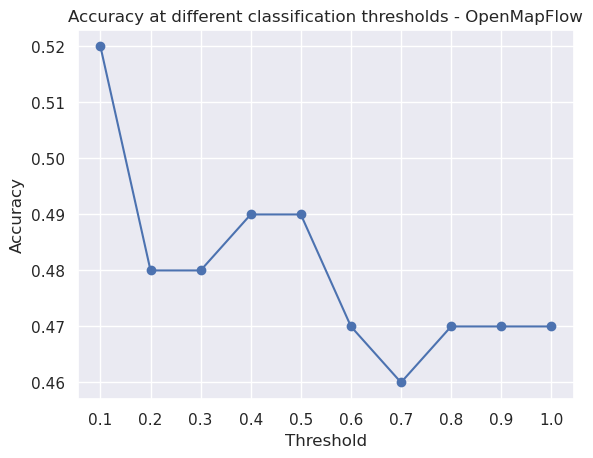

In [19]:
plt.plot(thresholds, accuracies_omf, marker='o')
plt.xticks(thresholds)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy at different classification thresholds - OpenMapFlow')
plt.show()